## 分析手写数字

考虑一个图像识别的问题：手写数字的自动识别。正常情况下，这个问题包括了**定位和识别图像中的字母**。
这里我们抄了一个捷径，**使用 Scikit-Learn 自带的预处理过的图像**。

### 载入和展示数字图像

使用Scikit-Learn的数据访问接口来载入这些图像并且查看一下数据内容：

In [1]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.images.shape

(1797, 8, 8)

图像数据是三维数组：1797个样本每个包括8 × 8像素的图。展示前100张：

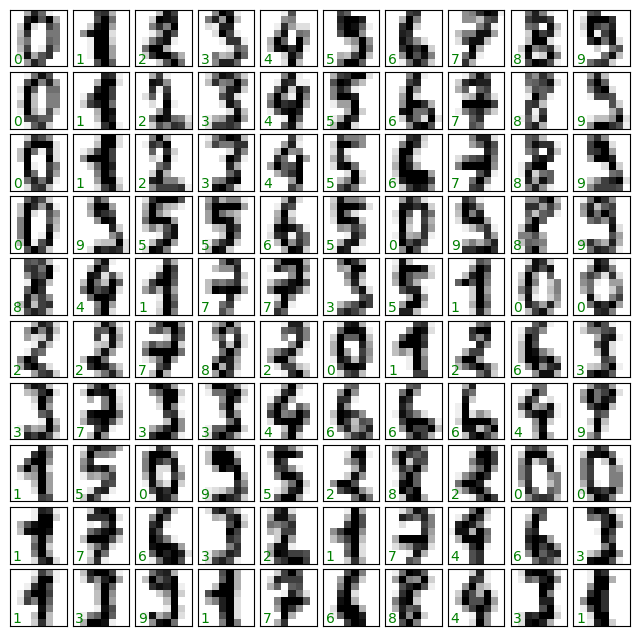

In [2]:
import matplotlib.pyplot as plt

# 10 行 10 列
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
# 绿的是 标签值
for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
            transform=ax.transAxes, color='green')

为了要在 Scikit-Learn 中使用这个数据集，我们需要一个二维的 **[n_samples, n_features]** 数据表示。在本例中我们可以将图像中的每个像素点当成一个特征：也就是说，通过将每个图像的像素数组平铺展开成一个长度为 64 的一维数组。除此之外，我们还需要目标数组，如上图一样是每张图标记的数字组成的数组。这两个量已经在数据集中內建好了，分别叫做 data 和 target 属性：

In [3]:
X = digits.data
X.shape

(1797, 64)

In [4]:
y = digits.target
y.shape

(1797,)

我们看到一共有1797个样本和64个特征。

下面我们在手写数字上应用分类算法。将数据集分为训练集和测试集，然后将这些训练数据拟合到SVM模型中：

In [5]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [6]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf', class_weight='balanced')

最后，我们可以使用网格查找交叉验证来检验模型超参数的组合。这里我们会调整`C`（用来控制边缘硬度）和`gamma`（用来控制径向基函数核的大小），从中找到最佳模型：

In [7]:
from sklearn.model_selection import GridSearchCV

# 注意：https://blog.csdn.net/qq_22592457/article/details/103700124
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(svc, param_grid, cv=3)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1.59 s, sys: 8.48 ms, total: 1.6 s
Wall time: 1.6 s
{'C': 5, 'gamma': 0.0005}


最优值应该落在网格的中央位置；如果它们落在边缘位置，我们应该考虑扩大网格来确保我们找到了最优值。
现在我们有了经过交叉验证后的模型，可以用来预测测试数据上的标签了，这些数据是模型从来没有接触过的：

In [8]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

我们已经预测了我们的模型，我们可以将得到的预测结果和测试集的目标向量进行比较得到模型的准确率：

In [9]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, yfit)

0.9933333333333333

使用这个非常简单的模型，我们得到了大约80%的数字分类的准确率。然而这个数字并不能告诉我们哪里出错了，输出混淆矩阵是一个好办法，可以使用Scikit-Learn计算它并使用Seaborn绘制图表：

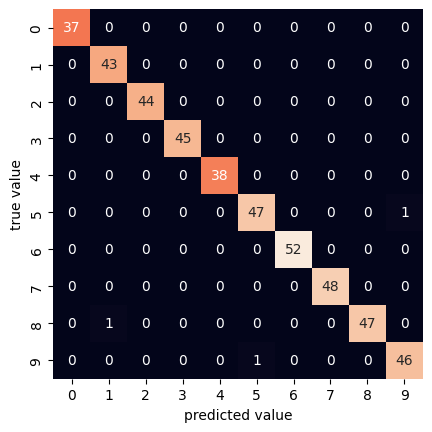

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(ytest, yfit)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

上图为我们展示了哪些数字更容易被错误标记：例如一个样本数字5被错误分类到了数字9。另一种直观展示模型准确率的方法是绘制输入的数字图像，还有它们预测的标签。我们使用绿色展示预测正确的标签，红色展示错误的标签：

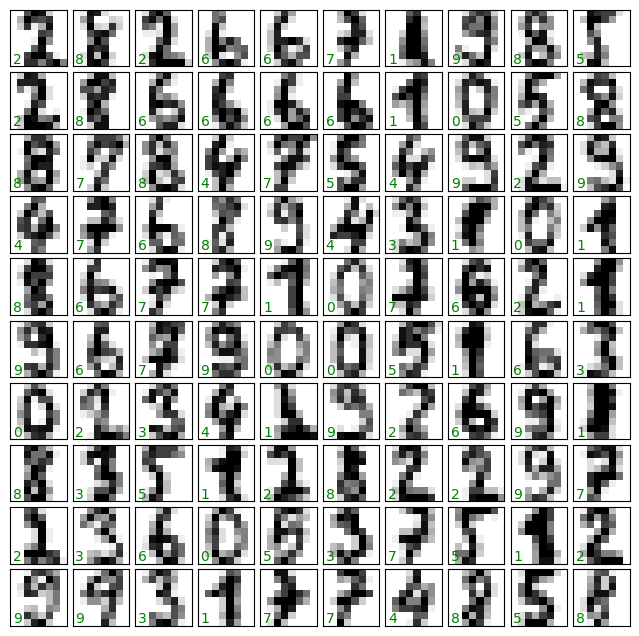

In [11]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 8, 8)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(yfit[i]),
            transform=ax.transAxes,
            color='green' if (ytest[i] == yfit[i]) else 'red')

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

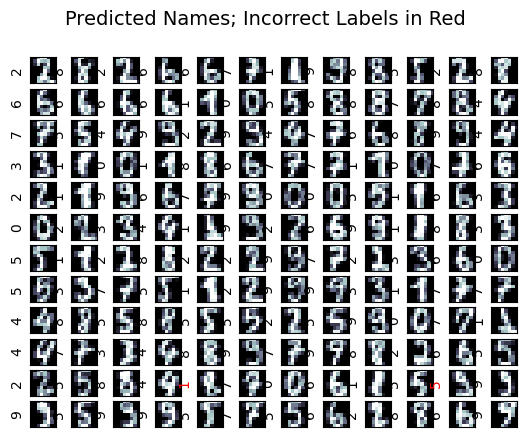

In [12]:
# 另外一种显示方式
fig, ax = plt.subplots(12, 12)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(8, 8), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(digits.target_names[yfit[i]],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

我们可以使用分类报告更好的得到评估器的性能估计，报告中我们对每个标签都进验证得出统计数据：

In [13]:
from sklearn.metrics import classification_report
target_names=list(map(str,digits.target_names))
print(classification_report(ytest, yfit,
                            target_names=target_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.98      1.00      0.99        43
           2       1.00      1.00      1.00        44
           3       1.00      1.00      1.00        45
           4       1.00      1.00      1.00        38
           5       0.98      0.98      0.98        48
           6       1.00      1.00      1.00        52
           7       1.00      1.00      1.00        48
           8       1.00      0.98      0.99        48
           9       0.98      0.98      0.98        47

    accuracy                           0.99       450
   macro avg       0.99      0.99      0.99       450
weighted avg       0.99      0.99      0.99       450



在真实的数字识别任务中，数字的照片并没有预先裁剪成一个图像，与例子中的唯一区别在于特征选择部分：你可能需要使用一个复杂得多的算法来找到数字，并将其中像素中独立的特征提取出来。
有许多 OCR 模型可以解决该问题。